## Oil-injection Screw Compressor Fault Classification

    
    1. This Notebook corresponds to the Oil-injection Screw Compressor Fault classification with the help of Convolution Neural Network by using Short Time Fourier Transform Spectrograms.
    
    2. The data is obtained from PHM 2021 Asia Pacific Data Challenge.
    
### Data Reference: 
    1. http://phmap.org/data-challenge/
    2. https://drive.google.com/drive/folders/1Zcth6UhPfP3vM8YadHhCSmK6v4aEyOA7

### Import Libraries

In [1]:
import pandas as pd             # Pandas for dataframes
import numpy as np              # Numpy for array operations
import matplotlib.pyplot as plt # Matplotlib to plot
import tensorflow as tf         # Tensorlflow for deep learning
import time                     # Time Module for Timing
from sklearn.metrics import classification_report, confusion_matrix # Confusion and Classification Report
import itertools  # itertools

### Import Data

#### Read CSV Files

In [2]:
df1 = pd.read_csv('Data/train_1st_Bearing.csv')   # Read CSV File

#### Look at the shape of Data Frames

In [3]:
print('Train_1st_Bearing Shape:', df1.shape)    # Print the shape of data frame

Train_1st_Bearing Shape: (18979200, 3)


#### Look at the Data

In [4]:
df1.head() # Look at the data

,Unnamed: 0,1st_Bearing_c1,1st_Bearing_c2
0,0,-0.261178,1.530771
1,1,1.070614,-3.171052
2,2,-1.402249,-0.213261
3,3,0.609899,3.161540
4,4,-0.299414,-1.550640


#### Drop the unecessary columns

In [5]:
df1 = df1.drop(labels='Unnamed: 0', axis = 1)  # Drop columns 'Unnamed: 0'

#### Change the name of columns

In [6]:
columns = ['Motor', 'Screw'] # List containing the Name of new columns
df1.columns = columns # Change the name of columns
df1.head() # Look at the Data Frame

,Motor,Screw
0,-0.261178,1.530771
1,1.070614,-3.171052
2,-1.402249,-0.213261
3,0.609899,3.161540
4,-0.299414,-1.550640


#### Plot the Data

In [7]:
train_line = np.array([int(df1.shape[0]*0.75)]*100) # To plot Regions
y_array = np.linspace(-16,16,100)                   # To plot Regions
val_line = np.array([int(df1.shape[0]*0.98)]*100)   # To plot Regions
test_line = np.array([int(df1.shape[0])]*100)       # To plot Regions

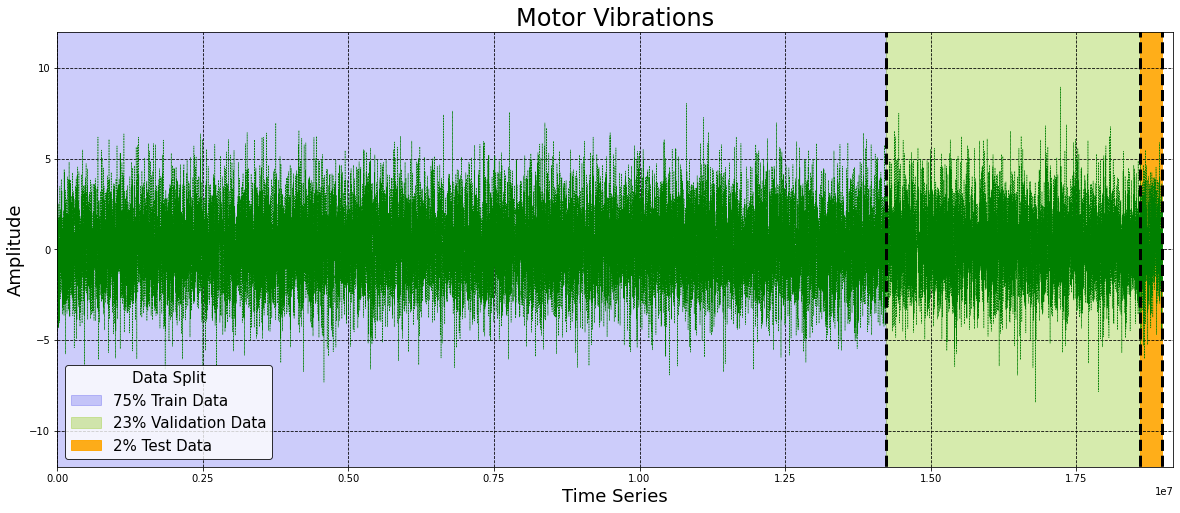

In [8]:
plt.figure(figsize = (20,8)) # Figure
plt.plot(df1['Motor'][0::1000], 'green', linewidth=0.5, linestyle='dashed') # Plot
plt.plot(train_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(val_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(test_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.fill_betweenx(y = y_array, x1=train_line, label='75% Train Data', color=[0.0,0.0,0.9,0.2]) # Fill color 
plt.fill_betweenx(y = y_array, x1=train_line, x2=val_line,label='23% Validation Data', color=[0.6039,0.8039,0.196,0.4]) # Fill color 
plt.fill_betweenx(y = y_array, x1=val_line, x2=test_line, label ='2% Test Data', color=[1.0,0.647,0.0,0.9])# Fill color 
plt.title('Motor Vibrations', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Series', fontdict={'fontsize':18}) # X-label
plt.ylabel('Amplitude', fontdict={'fontsize':18}) # Y-label
plt.xlim((0,int(df1.shape[0]+0.01*int(df1.shape[0])))) # Set x-limit
plt.ylim((-12,12)) # Set y-limit
plt.grid(True, color='black', linestyle='--') # Grid
plt.legend(fontsize=15, title='Data Split', loc=0, edgecolor='black', title_fontsize=15) # Legend
plt.show() # Show

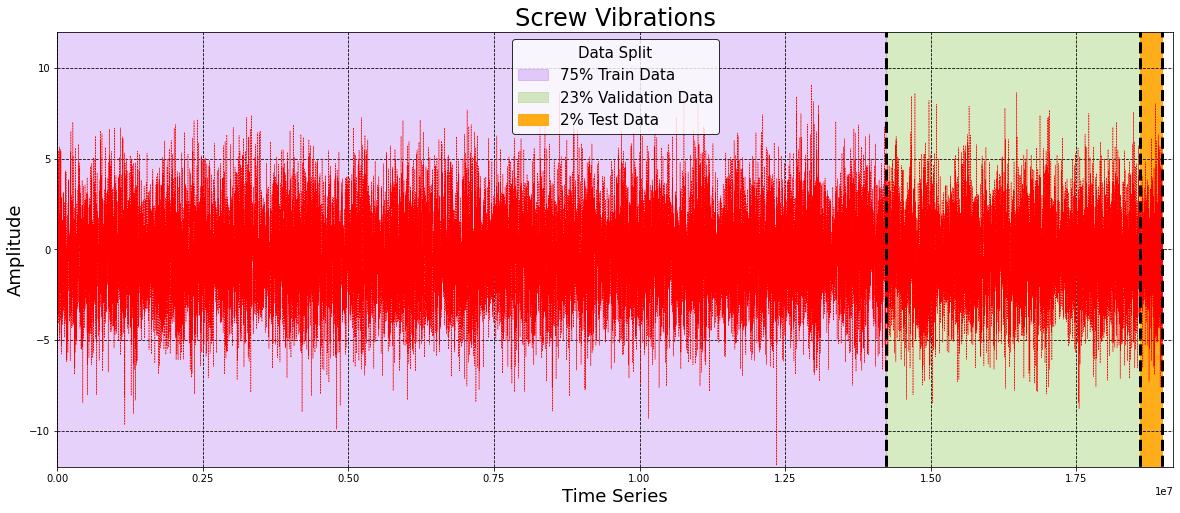

In [9]:
plt.figure(figsize = (20,8)) # Figure
plt.plot(df1['Screw'][0::1000], 'red', linewidth=0.5, linestyle='dashed') # Plot
plt.plot(train_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(val_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.plot(test_line, y_array, color = 'black', linestyle='dashed', linewidth=3) # Plot
plt.fill_betweenx(y = y_array, x1=train_line, label='75% Train Data', color=[0.5,0.1,0.9,0.2]) # Fill color 
plt.fill_betweenx(y = y_array, x1=train_line, x2=val_line,label='23% Validation Data', color=[0.6039,0.8039,0.4,0.4]) # Fill color 
plt.fill_betweenx(y = y_array, x1=val_line, x2=test_line, label ='2% Test Data', color=[1.0,0.647,0.0,0.9])# Fill color 
plt.title('Screw Vibrations', fontdict={'fontsize':24}) # Title
plt.xlabel('Time Series', fontdict={'fontsize':18}) # X-label
plt.ylabel('Amplitude', fontdict={'fontsize':18}) # Y-label
plt.xlim((0,int(df1.shape[0]+0.01*int(df1.shape[0])))) # Set x-limit
plt.ylim((-12,12)) # Set y-limit
plt.grid(True, color='black', linestyle='--') # Grid
plt.legend(fontsize=15, title='Data Split', loc=0, edgecolor='black', title_fontsize=15) # Legend
plt.show() # Show

### Discrete Fourier Transform

In [10]:
def DFT(x):
    '''Computes the Discrete Fourier Transform.
       Pass: Signal Array/List
       Return: Fourier Transform'''
    x = np.asarray(x, dtype=float) # Convert to array .
    N = x.shape[0]                 # Get the length of array.
    n = np.arange(N)               # Array with range of N
    k = n.reshape((N,1))           # For the Fourier coefficient indexes
    M = np.exp((-2j * np.pi * k * n)/N) # Exponential Matrix
    return np.matmul(M, x)              # Return the Fourier Transform

### Fast Fourier Transform

In [11]:
def FFT(x):
    '''Computes FFT of a Signal by using Recursing Algorithm.
       Pass: Signal Array/List
       Return: Fourier Transform'''
    x = np.asarray(x, dtype=float)   # Convert to array 
    N = x.shape[0]                   # Get the length of array. 
    if N%2>0:                        # The array must be a power of 2
        raise ValueError('The size of x must be a power of 2.')
    elif N<=2:                       # Compute DFT when length of array is less than 2
        return DFT(x)
    else:                            # Go on Recursing
        X_even = FFT(x[::2])         # Even Split
        X_odd  = FFT(x[1::2])        # Odd Split
        factor = np.exp(-2j * np.pi * np.arange(N)/N) # The exponential Factor
        
        # Return
        return np.concatenate([X_even + factor[:int(N/2)]*X_odd, 
                               X_even + factor[int(N/2):]*X_odd])# Concatenate all Even and Odd SPlits

### FFT Coeficients after Nyquest's Limit

In [12]:
def FFT_Nyquest(x):
    '''Gives FFT Coefficients after Nyquest Limits.
       Pass: Array.
       Return: Coefficients till Nyquest Limit.'''
    xs = FFT(x) # Get the FFT of the Array
    xs = xs[0:int(xs.shape[0]/2)] # Halve the array till Nyquest's Limit
    fft_coeff = np.abs(xs/xs.shape[0])**2 # Transform the Coefficients by taking the Absolute Value of Normalized FFT array and multiply by 2. 
    return fft_coeff # Return FFT Coefficients.

### Window Selection for STFT

In [13]:
def Window_Select(N, window=None, sigma=None, choice=False):
    '''Function for selecting window for STFT.
       Pass: Window Length, Type of Window, Sigma for Gaussian.
       Return: Window Function, Plot of the Window Function.'''
    
    n = np.arange(N)             # Length of window 
    if window == 'Rectangular':  # Rectangular Window
        w = np.where((n>0) & (n<N-1), 1, 0)
    elif window == 'Triangular': # Triangular Window
        w = (2/N)*((N/2) - np.abs(n -(N/2)))
    elif window == 'Welch':      # Welch Wndow
        w = 1 - ((n - 0.5*(N-1))/(0.5*(N+1)))**2
    elif window == 'Bartlett':   # Bartlett Window
        w = (2/(N-1)) * ((N-1)/2 - np.abs(n - (N-1)/2))
    elif window == 'Hann':       # Hann Window
        w = 0.5*(1 - np.cos((2*np.pi*n)/(N-1)))
    elif window == 'Hamming':    # Hamming Window
        w = 0.54 - 0.46*np.cos((2*np.pi*n)/(N-1))
    elif window == 'Blackman':   # Balckman Window
        w = 0.42 - 0.5*np.cos((2*np.pi*n)/(N-1)) + 0.08*np.cos((4*np.pi*n)/(N-1))
    elif window == 'Gaussian':   # Gaussian Window
        w = np.exp(-0.5*((n-N/2)/(sigma*N/2))**2)
    
    # Plot the Window
    if choice == True:
        plt .figure(figsize = (5,3)) # Figure Layout
        plt.plot(w,'red')            # Plot Window
        plt.title(window+' Window', fontdict={'fontsize':15}) # Title
        plt.xlim(0,N)  # X-Limit
        plt.ylim(0,1.1)# Y-Limit
        plt.grid(True) # Grid
        plt.show()     # Show
    
    return w  # Return

### Spectrogram

In [1]:
def Spectrogram(x, window_length, overlap, window_type='Hann'):
    '''Create Spectrogram.
       Pass: Array to be STFT-ed, Window Length, Overlap and Window type[Default = "Hann"].
       Return: spectrogram Matrix.'''
    
    spectrogram = []           # Empty List to store spectrogram
    w = Window_Select(window_length, window_type) # Select Window
    
    # Get 64 x 64 Size Matrix
    for i in range(window_length):
        if i == 0:  # Start and End indices
            start = 0
            end = window_length
        else:       # Start and End indices
            start = window_length*i - overlap
            end = window_length*(i+1) - overlap
        transform_window = x[start:end]   # Get the values from the 4096 size array
        if len(transform_window) < window_length: # Break when we do not have the window length size array
            break
        else: # DO STFT
            transform_window = transform_window * w # Multiply the Array with the Window array
            fft = FFT_Nyquest(transform_window) # Get the FFT Coefficients till Nyquest's Limit
            spectrogram.append(fft)              # Append to list
            
    spectrogram = np.array(spectrogram).T # Transform List to Array and take the Transpose.
    spectrogram = 10*np.log10(spectrogram) # Convert to Log10 values for better visualization
    return spectrogram # Return the spectrogram

### Note:
    1. Our Spectogram will be 32 x 32 Size Image.
    2. We will be slicing the dataframes with a slice size of 2048.
    3. The overlap will be 16 and window length will be 64.

### Extract the Data and Create Spectogram for each Class.
    
    1. Since, the data is huge, loading all dataframes will memory intensive, so a function will be created 
       to read, clean, normalize and prepare data file by file.
  
    2. This function will also create the Spectograms.
    
    3. Interpolation methods for image saving:
        None, 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming',
        'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'

In [52]:
def Create_Spectrograms(csv_file=None, class_name=None, stri=None, length_slice=None, window_type='Hann', window_length =None, overlap=None):
    '''Cleans data and Creates Spectrograms for each class.
       Pass: CSV File, Fault Class Name, String to differentiate while saving, Length of Slice in power of 2, Window Type for STFT,
             Window Length for STFT, Overlap Length.
       Returns: Creates spectrogram'''
    
    # Data
    df = pd.read_csv(csv_file) # Read CSV File
    df = df.drop(labels='Unnamed: 0', axis = 1)  # Drop columns 'Unnamed: 0'
    columns = ['Motor', 'Screw'] # List containing the Name of new columns
    df.columns = columns # Change the name of columns
    
    # Iterate Through Columns
    for labels in columns:
        data_frame = df[labels] # Column by Column
        data_frame = np.array(data_frame) # Convert to 1-D Array
        li_time = []
        # Normalize to range ==> [-1, 1]
        array = ((data_frame-np.max(data_frame)) + (data_frame-np.min(data_frame)))/(np.max(data_frame) - np.min(data_frame))
        # Train Test Split number of Images
        n_total = int(array.shape[0]/length_slice) # Total Set
        n_train = int(array.shape[0]/length_slice * 0.75) # 75 % Training set
        n_val   = int(array.shape[0]/length_slice * 0.23)  # 23 % Validation set
        print(f'Total Number of Images in {labels} set:', n_total) # Print total images
        
        for i in range(n_total): # Loop to create images
            if i<10:
                start = time.time() # Start Time
            array_slice = array[(length_slice*i) : (length_slice*(i+1))] # Slice Array
            spectrogram = Spectrogram(array_slice, window_length, overlap, window_type) # Get the spectrogram
            # Save in Particular Folders

            # Train
            if i<=n_train:
                plt.imsave(f"Images/train/{class_name}/{class_name}_{stri}_{labels}_{i}.jpeg", spectrogram, cmap=plt.cm.terrain, origin='lower')
            # Validation 
            elif i>n_train and i<=(n_train+n_val):
                plt.imsave(f"Images/validation/{class_name}/{class_name}_{stri}_{labels}_{i}.jpeg", spectrogram, cmap=plt.cm.terrain, origin='lower')
            elif i>(n_train+n_val):
                plt.imsave(f"Images/test/{class_name}/{class_name}_{stri}_{labels}_{i}.jpeg", spectrogram, cmap=plt.cm.terrain, origin='lower')
            if i<10:
                end = time.time() # End Time
                li_time.append(np.around(end-start, 4)) # Compute time required
            if i==10:
                print('Estimated Time:', np.around(np.average(li_time), 3), 'seconds') # Print the Average time Needed
                print('Total Time Estimated:', np.around((np.average(li_time)*n_total)/(60), 4), 'min')

#### Spectograms for Bearing-Fault  Class

In [53]:
Create_Spectrograms(csv_file='Data/train_1st_Bearing.csv', class_name='Bearing-Fault', stri='1st',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 9267
Estimated Time: 0.044 seconds
Total Time Estimated: 6.7217 min
Total Number of Images in Screw set: 9267
Estimated Time: 0.048 seconds
Total Time Estimated: 7.463 min


In [54]:
Create_Spectrograms(csv_file='Data/train_2nd_Bearing.csv', class_name='Bearing-Fault', stri='2nd',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 20029
Estimated Time: 0.05 seconds
Total Time Estimated: 16.7409 min
Total Number of Images in Screw set: 20029
Estimated Time: 0.056 seconds
Total Time Estimated: 18.7271 min


#### Spectograms for Belt-Looseness-High Class

In [56]:
Create_Spectrograms(csv_file='Data/train_1st_high.csv', class_name='Belt-Looseness-High', stri='1st',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 2140
Estimated Time: 0.047 seconds
Total Time Estimated: 1.6838 min
Total Number of Images in Screw set: 2140
Estimated Time: 0.046 seconds
Total Time Estimated: 1.6474 min


#### Spectograms for Belt-Looseness Class

In [57]:
Create_Spectrograms(csv_file='Data/train_1st_Looseness.csv', class_name='Belt-Looseness', stri='1st',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 3135
Estimated Time: 0.045 seconds
Total Time Estimated: 2.333 min
Total Number of Images in Screw set: 3135
Estimated Time: 0.048 seconds
Total Time Estimated: 2.5043 min


In [58]:
Create_Spectrograms(csv_file='Data/train_2nd_Looseness.csv', class_name='Belt-Looseness', stri='2nd',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 15803
Estimated Time: 0.053 seconds
Total Time Estimated: 14.0041 min
Total Number of Images in Screw set: 15803
Estimated Time: 0.051 seconds
Total Time Estimated: 13.3272 min


#### Spectograms for Normal Class

In [59]:
Create_Spectrograms(csv_file='Data/train_1st_Normal.csv', class_name='Normal', stri='1st',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 7645
Estimated Time: 0.043 seconds
Total Time Estimated: 5.5248 min
Total Number of Images in Screw set: 7645
Estimated Time: 0.044 seconds
Total Time Estimated: 5.656 min


In [60]:
Create_Spectrograms(csv_file='Data/train_3rd_Normal.csv', class_name='Normal', stri='2nd',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 25833
Estimated Time: 0.046 seconds
Total Time Estimated: 19.9129 min
Total Number of Images in Screw set: 25833
Estimated Time: 0.104 seconds
Total Time Estimated: 44.7643 min


#### Spectograms for Unbalance Class

In [61]:
Create_Spectrograms(csv_file='Data/train_1st_Unbalance.csv', class_name='Unbalance', stri='1st',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 5751
Estimated Time: 0.051 seconds
Total Time Estimated: 4.897 min
Total Number of Images in Screw set: 5751
Estimated Time: 0.047 seconds
Total Time Estimated: 4.5136 min


In [62]:
Create_Spectrograms(csv_file='Data/train_2nd_Unbalance.csv', class_name='Unbalance', stri='2nd',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 14688
Estimated Time: 0.044 seconds
Total Time Estimated: 10.6488 min
Total Number of Images in Screw set: 14688
Estimated Time: 0.052 seconds
Total Time Estimated: 12.6268 min


In [63]:
Create_Spectrograms(csv_file='Data/train_3rd_Unbalance.csv', class_name='Unbalance', stri='3rd',
                   length_slice=2048, window_length=64, overlap=16)

Total Number of Images in Motor set: 11531
Estimated Time: 0.043 seconds
Total Time Estimated: 8.3504 min
Total Number of Images in Screw set: 11531
Estimated Time: 0.051 seconds
Total Time Estimated: 9.8206 min


### Peek at the Spectrograms

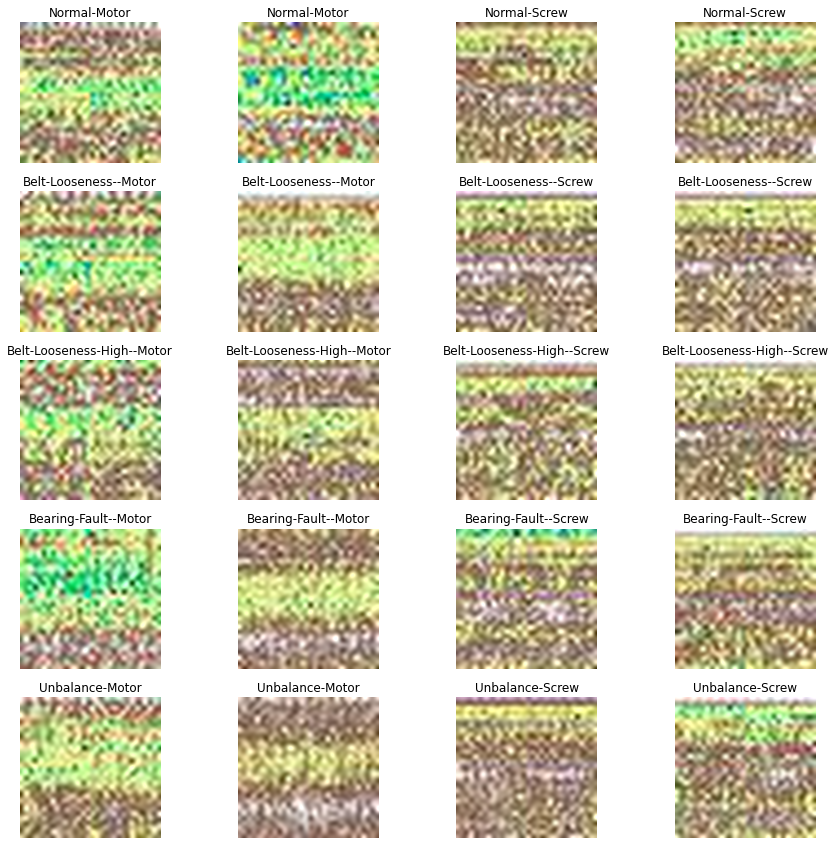

In [25]:
rows = 5 # Number of Rows
columns = 4 # Number of Columns
list_images = ['Normal/Normal_1st_Motor_9.jpeg', 'Normal/Normal_2nd_Motor_4272.jpeg', 'Normal/Normal_1st_Screw_3695.jpeg', 'Normal/Normal_2nd_Screw_14129.jpeg',
               'Belt-Looseness/Belt-Looseness_1st_Motor_25.jpeg', 'Belt-Looseness/Belt-Looseness_2nd_Motor_4414.jpeg', 'Belt-Looseness/Belt-Looseness_1st_Screw_1588.jpeg', 'Belt-Looseness/Belt-Looseness_2nd_Screw_5218.jpeg',
               'Belt-Looseness-High/Belt-Looseness-High_1st_Motor_90.jpeg', 'Belt-Looseness-High/Belt-Looseness-High_1st_Motor_1135.jpeg', 'Belt-Looseness-High/Belt-Looseness-High_1st_Screw_337.jpeg', 'Belt-Looseness-High/Belt-Looseness-High_1st_Screw_1441.jpeg',
               'Bearing-Fault/Bearing-Fault_1st_Motor_138.jpeg', 'Bearing-Fault/Bearing-Fault_2nd_Motor_9129.jpeg', 'Bearing-Fault/Bearing-Fault_1st_Screw_5112.jpeg', 'Bearing-Fault/Bearing-Fault_2nd_Screw_14714.jpeg',
               'Unbalance/Unbalance_1st_Motor_2550.jpeg', 'Unbalance/Unbalance_2nd_Motor_6835.jpeg', 'Unbalance/Unbalance_1st_Screw_2149.jpeg', 'Unbalance/Unbalance_3rd_Screw_2368.jpeg',
              ]
list_title = ['Normal-Motor', 'Normal-Motor', 'Normal-Screw', 'Normal-Screw',
              'Belt-Looseness--Motor', 'Belt-Looseness--Motor', 'Belt-Looseness--Screw', 'Belt-Looseness--Screw',
              'Belt-Looseness-High--Motor', 'Belt-Looseness-High--Motor', 'Belt-Looseness-High--Screw', 'Belt-Looseness-High--Screw',
              'Bearing-Fault--Motor', 'Bearing-Fault--Motor', 'Bearing-Fault--Screw', 'Bearing-Fault--Screw',
              'Unbalance-Motor', 'Unbalance-Motor', 'Unbalance-Screw', 'Unbalance-Screw']

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize =(15,15), squeeze=0, sharex=True, sharey=True) # Subplots
axes = np.array(axes) # Makes Array to Iterate

j=0
for i, ax in enumerate(axes.reshape(-1)):
    img = plt.imread('Images/train/'+list_images[j]) # Read Image
    ax.imshow(img, interpolation='lanczos', origin='lower') # Show Image
    ax.set_title(list_title[j]) # St Title
    ax.set_axis_off() # Axis Off
    j=j+1 # Increment

## Classification

#### Define Parameters 

In [5]:
image_size = 32  # Size of Image
num_classes = 5  # Number of Output Classes
batch_size = 128 # Batch Size
dir_train = 'Images/train/' # Train Directory
dir_val = 'Images/validation/' # Validation Directory
dir_test = 'Images/test/' # Test Directory

#### Instantiate ImageDataGenerator

In [3]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator() # ImageDataGenerator

#### Train Set

In [6]:
train = data_generator.flow_from_directory(dir_train, batch_size = batch_size, shuffle = True,
                                           class_mode = 'sparse', target_size = (image_size,image_size))

Found 173752 images belonging to 5 classes.


#### Validation Set

In [7]:
valid = data_generator.flow_from_directory(dir_val, batch_size = batch_size, shuffle = True,
                                           class_mode = 'sparse', target_size = (image_size,image_size))

Found 53270 images belonging to 5 classes.


#### Test Set

In [52]:
test = data_generator.flow_from_directory(dir_test, batch_size = batch_size, shuffle = False,
                                          class_mode = 'sparse', target_size = (image_size,image_size))

Found 4622 images belonging to 5 classes.


### Model

In [13]:
model = tf.keras.Sequential(name='Screw_Compressor_Fault_Classifier')  # Sequential Layer
model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3), name='Input_Layer'))# Input Layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/255., name='Rescaler')) # Rescaling 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation ='relu', name='Conv_1')) # Convolution 
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='Pool_1')) # Pooling Layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation ='relu', name='Conv_2')) # Convolution 
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same', name='Pool_2')) # Pooling Layer
model.add(tf.keras.layers.Flatten(name='Flatten')) # Flatten Layer
model.add(tf.keras.layers.Dense(units=128, activation='relu', name='Dense_1')) # Dense Layer
model.add(tf.keras.layers.Dropout(0.2, name='Dropout_1')) # Dropout Layer
model.add(tf.keras.layers.Dense(units=32, activation='relu', name='Dense_2')) # Dense Layer
model.add(tf.keras.layers.Dropout(0.2, name='Dropout_2')) # Dropout Layer
model.add(tf.keras.layers.Dense(units=16, activation='relu', name='Dense_3')) # Dense Layer
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', name='Classifier')) # Output Layer

#### Summarize

In [14]:
model.summary()

Model: "Screw_Compressor_Fault_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescaler (Rescaling)         (None, 32, 32, 3)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 16, 16, 64)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 32)        18464     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 8, 8, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Dense_1 (Dense)              (Non

#### Define Optimizer, Loss Function and Metircs

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Adam Optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy() # Loss Function
metrics = tf.keras.metrics.SparseCategoricalAccuracy() # Accuracy Metrics

#### Compile Model

In [16]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics]) # Compile Model

#### CSV Logger Callback

In [17]:
csv_logger = tf.keras.callbacks.CSVLogger('Screw_Compressor_Fault_Classifier.csv') # CSV Logger

#### Define Epochs

In [18]:
epochs = 10 # Num of Epochs

#### Train Model

In [20]:
history = model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=valid,
                    shuffle=True, callbacks=[csv_logger], verbose=1) # Fit Model

Epoch 1/10
1358/1358 [==============================] - 4656s 3s/step - loss: 0.4421 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.1083 - val_sparse_categorical_accuracy: 0.9609
Epoch 2/10
1358/1358 [==============================] - 4259s 3s/step - loss: 0.1376 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.0698 - val_sparse_categorical_accuracy: 0.9751
Epoch 3/10
1358/1358 [==============================] - 3537s 3s/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.0498 - val_sparse_categorical_accuracy: 0.9834
Epoch 4/10
1358/1358 [==============================] - 4711s 3s/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0488 - val_sparse_categorical_accuracy: 0.9833
Epoch 5/10
1358/1358 [==============================] - 4587s 3s/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9873
Epoch 6/10
1358/1358 [==============================] - 4730s 3s/step - loss: 0.

#### Save Model

In [21]:
tf.keras.models.save_model(model, 'Screw_Compressor_Fault_Classfier.model', include_optimizer=True, overwrite=True) # Save

INFO:tensorflow:Assets written to: Screw_Compressor_Fault_Classfier.model\assets


INFO:tensorflow:Assets written to: Screw_Compressor_Fault_Classfier.model\assets


#### Look at the saved Dataframe of CSV logger

In [119]:
df_csvlogger = pd.read_csv('Screw_Compressor_Fault_Classifier.csv') # Read CSV File
df_csvlogger.head(epochs)

,epoch,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0,0.442127,0.830327,0.108316,0.960935
1,1,0.137587,0.953906,0.069795,0.975108
2,2,0.093692,0.968628,0.049773,0.983424
3,3,0.076546,0.974521,0.048833,0.983349
4,4,0.063486,0.978607,0.039693,0.987272
5,5,0.058346,0.980944,0.037133,0.987216
6,6,0.050184,0.983569,0.055352,0.982279
7,7,0.046943,0.984518,0.031497,0.989300
8,8,0.043187,0.985479,0.037156,0.987610
9,9,0.040680,0.986475,0.028724,0.990839


#### Plot Loss and Metrics

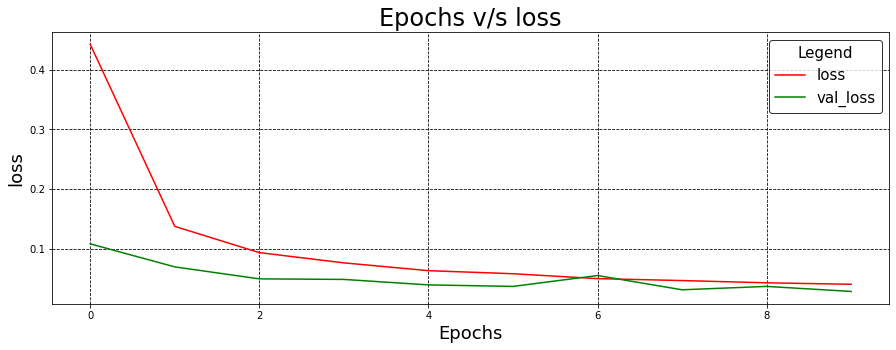

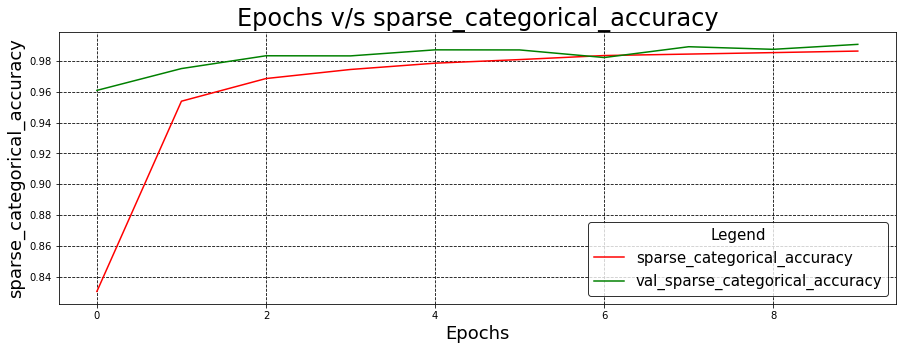

In [29]:
def plot(history, string):
    '''Plots Losses/Accuracy.'''
    plt.figure(figsize=(15,5)) # Figure
    plt.plot(history.history[string], color='red', label=string) # Train Loss/Accuracy
    plt.plot(history.history['val_'+string], color='green', label='val_'+string) # Validation Loss/Accuracy
    plt.grid(True, color='black', linestyle='--') # Grid
    plt.legend(fontsize=15, title='Legend', loc=0, edgecolor='black', title_fontsize=15) # Legend
    plt.title(f'Epochs v/s {string}', fontdict={'fontsize':24}) # Title
    plt.xlabel('Epochs', fontdict={'fontsize':18}) # X-Label
    plt.ylabel(string, fontdict={'fontsize':18}) # Y-Label
    plt.show()
    return None

# Call
plot(history, 'loss') # Loss
plot(history, 'sparse_categorical_accuracy') # Accuracy

### Prediction

#### Load Model

In [30]:
model = tf.keras.models.load_model('Screw_Compressor_Fault_Classfier.model') # Load

#### Evaluate Test Set

In [34]:
evaluate_test = model.evaluate(test, verbose=1) # Evaluate
print('Loss: ', np.around(evaluate_test[0],3)) # Print Loss
print('Performance: ', np.around(evaluate_test[1],3)*100, '%') # Print Accuracy

37/37 [==============================] - 4s 105ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9846
Loss:  0.051
Performance:  98.5 %


#### Predict Test Set

In [72]:
y_pred = model.predict(test, verbose=1) # Predict

37/37 [==============================] - 4s 118ms/step


#### Helper Function
        
     1. We are going to create a function which will predict what kind of image belongs to which class

In [35]:
# For Printing 
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [45]:
def predict(img, region=None):
    '''Predicts the class of the image.
       Pass: Image, Resized Tensor Image, Region.'''
    print(f'Reality: The Compressor is in {color.BOLD} {color.PURPLE} {region} {color.END} mode!')
    print('***********************************************************************************************')
    # Plot image
    plt.figure(figsize=(3,3)) # Figure
    plt.imshow(img, interpolation='sinc', origin='lower') # Plot Image
    plt.title(f'Spectrogram of {region} Condition', fontdict={'fontsize':18}) # Title
    plt.axis('off')# Axes off
    plt.show() # Show image
    
    # Predict
    img = np.expand_dims(img, axis=0) # Expands into a 4-D array as CNN expects 4-D Array
    prediction = model.predict(img)   # Predict 
    index = prediction.argmax() # Get the index of highest probability.
    compressor_mode = class_dict[index] # Get the class of wear

    print(f'''Prediction: The Compressor is in {color.BOLD}{color.GREEN} {compressor_mode.capitalize()}{color.END} mode!''') # Print
    print(f'Prediction Accuracy: {color.BOLD} {np.around(prediction[0][index]*100,2)}% {color.END}') # Print
    print('***********************************************************************************************')
    return None

#### Get the Labels of Classes

In [46]:
class_dict = test.class_indices # Get Dictionary of Class Names as key and Index as item
print('Original:', class_dict) # Print

# Reverse Dictionary
class_dict = dict((values,key) for key,values in class_dict.items()) # Reverse
print('Reverse:', class_dict)

Original: {'Bearing-Fault': 0, 'Belt-Looseness': 1, 'Belt-Looseness-High': 2, 'Normal': 3, 'Unbalance': 4}
Reverse: {0: 'Bearing-Fault', 1: 'Belt-Looseness', 2: 'Belt-Looseness-High', 3: 'Normal', 4: 'Unbalance'}


#### Predict Normal

Reality: The Compressor is in   Normal  mode!
***********************************************************************************************


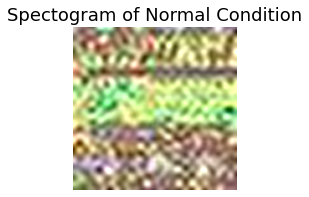

Prediction: The Compressor is in  Normal mode!
Prediction Accuracy:  99.69% 
***********************************************************************************************


In [47]:
img_dir = 'Images/test/Normal/Normal_1st_Motor_7502.jpeg' # Image Directory from Test set
img = plt.imread(img_dir) # Read Image

# Predict
predict(img, region='Normal')

#### Predict Belt-Looseness

Reality: The Compressor is in   Belt-Looseness  mode!
***********************************************************************************************


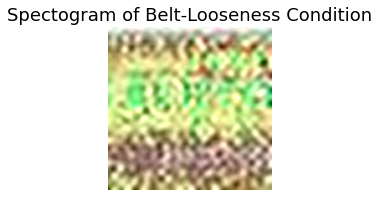

Prediction: The Compressor is in  Belt-looseness mode!
Prediction Accuracy:  100.0% 
***********************************************************************************************


In [48]:
img_dir = 'Images/test/Belt-Looseness/Belt-Looseness_2nd_Motor_15607.jpeg' # Image Directory from Test set
img = plt.imread(img_dir) # Read Image

# Predict
predict(img, region='Belt-Looseness')

#### Pedict Belt-Looseness-High

Reality: The Compressor is in   Belt-Looseness-High  mode!
***********************************************************************************************


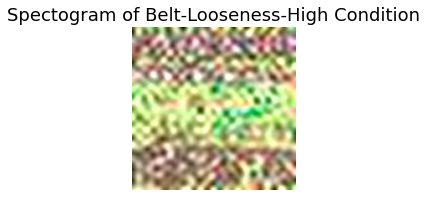

Prediction: The Compressor is in  Belt-looseness-high mode!
Prediction Accuracy:  99.6% 
***********************************************************************************************


In [49]:
img_dir = 'Images/test/Belt-Looseness-High/Belt-Looseness-High_1st_Motor_2120.jpeg' # Image Directory from Test set
img = plt.imread(img_dir) # Read Image

# Predict
predict(img, region='Belt-Looseness-High')

#### Predict Unbalance

Reality: The Compressor is in   Unbalance  mode!
***********************************************************************************************


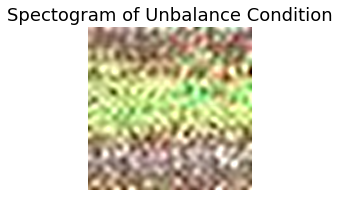

Prediction: The Compressor is in  Unbalance mode!
Prediction Accuracy:  100.0% 
***********************************************************************************************


In [50]:
img_dir = 'Images/test/Unbalance/Unbalance_2nd_Motor_14498.jpeg' # Image Directory from Test set
img = plt.imread(img_dir) # Read Image

# Predict
predict(img, region='Unbalance')

#### Predict Bearing-Fault

Reality: The Compressor is in   Bearing-Fault  mode!
***********************************************************************************************


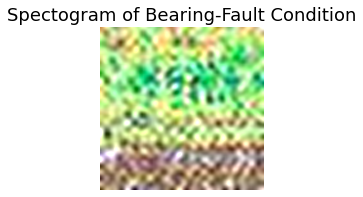

Prediction: The Compressor is in  Bearing-fault mode!
Prediction Accuracy:  100.0% 
***********************************************************************************************


In [51]:
img_dir = 'Images/test/Bearing-Fault/Bearing-Fault_1st_Motor_9167.jpeg' # Image Directory from Test set
img = plt.imread(img_dir) # Read Image

# Predict
predict(img, region='Bearing-Fault')

### Confusion Matrix

In [73]:
y_pred = np.argmax(y_pred, axis=1) # Get the index maximum probability

In [114]:
# Get the names of labels for confusion Matrix
target_names = []
for key in train.class_indices:
    target_names.append(key.capitalize())

#### Helper Function to plot Confusion Matrix

In [115]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    """ This function prints and plots the confusion matrix. """

    plt.figure(figsize=(10,10)) # Figure 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Plot Image
    plt.title(title, fontdict={'fontsize':24}) # Title
    plt.colorbar()   # Show Colorbar
    tick_marks = np.arange(len(classes)) # Array with elements as nuber of classes i.e. [0,1,2,3,4]
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14, fontweight='semibold') # X-Ticks as class names
    plt.yticks(tick_marks, classes, fontsize=14, fontweight='semibold') # Y-Ticks as class names
    
    # Show the number of classified images in the Confusion Matrix Box
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black", fontsize=14, fontweight='semibold')
    
    plt.tight_layout() # Tight Layout
    plt.ylabel('True label', fontdict={'fontsize':18}) # Y-label
    plt.xlabel('Predicted label', fontdict={'fontsize':18}) # X-label
    plt.show() # Show 

#### Plot Confusion Matrix

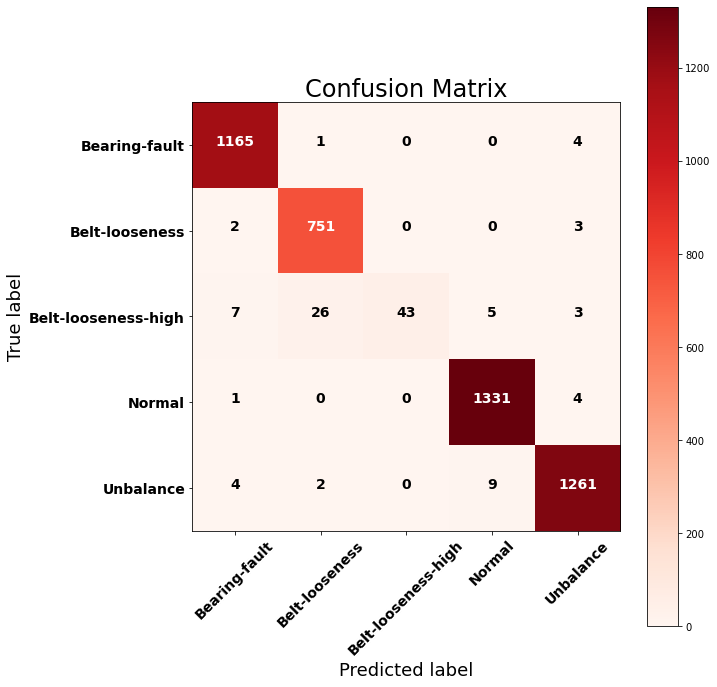

In [116]:
cm = confusion_matrix(test.classes, y_pred) # Confusion Matrix Array
plot_confusion_matrix(cm, target_names, title='Confusion Matrix') # Plot CM

#### Note
    
    1. It looks like the model did not classify Belt-Looseness-High Mode class properly as there were many 
       images which were falsely classified as other modes particularly with Belt-Looseness.
       
    2. Maybe both these modes have similar vibration characterstics and thus can be classified as one class.
       Thereby, if we reduce the number of classes from 5 to 4, maybe out accuracy may increase,

### Get the Classification Report

In [82]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

      Bearing-Fault       0.99      1.00      0.99      1170
     Belt-Looseness       0.96      0.99      0.98       756
Belt-Looseness-High       1.00      0.51      0.68        84
             Normal       0.99      1.00      0.99      1336
          Unbalance       0.99      0.99      0.99      1276

           accuracy                           0.98      4622
          macro avg       0.99      0.90      0.93      4622
       weighted avg       0.98      0.98      0.98      4622

